In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
# Load data
train = pd.read_csv(os.path.join('DigitRecognizer','train.csv'))
test = pd.read_csv(os.path.join('DigitRecognizer','test.csv'))

In [16]:
y_train = train["label"]
x_train = train.drop(labels = ["label"],axis = 1) 

In [17]:
del train 

In [18]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Missing values

In [38]:
x_train.isnull().any().sum()

0

In [39]:
y_train.isnull().any().sum()

0

In [28]:
test.isnull().any().sum()

0

No missing data in train and test sets

# Data Preprocessing

In [8]:
# Normalize data
x_train = x_train / 255.0

In [9]:
# Reshape image into 3D arrays
x_train = x_train.values.reshape(-1,28,28,1) 

In [10]:
# Encode labels 
y_train = keras.utils.to_categorical(y_train, num_classes = 10)

In [11]:
# Train val split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=2)

# Prepare model

Note: I learnt the coding techniques for building a CNN from Hands-On Machine Learning (by Aurelien Geron) as well as Yassine Ghouzam's Kaggle notebook

### Define layers

In [12]:
model = Sequential([
    
    # Layer 1
    keras.layers.Conv2D(filters = 32, kernel_size = 5, padding = "same", activation = "relu", input_shape = [28,28,1]),
    keras.layers.MaxPooling2D (pool_size = 2, strides = 2),
 
    # Layer 2
    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
    keras.layers.MaxPooling2D (pool_size = 2, strides = 2),
    
    keras.layers.Flatten(),
    
    # Layer 3
    keras.layers.Dense(256, activation = "relu"), 
    keras.layers.Dropout(0.5),
     
    #Layer 4
    keras.layers.Dense(10, activation = "softmax")
])

### Compile model

In [ ]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [15]:
model.compile(optimizer = opt, 
              loss = "categorical_crossentropy", 
              metrics=["accuracy"])

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  # horizontal shift (relative to total width)
        height_shift_range=0.1,  # vertical shift (relative to total height)
)  

In [16]:
datagen.fit(x_train)

### Callbacks

In [19]:
checkpoint_cb = ModelCheckpoint("mnist.h5",                                                 
                                monitor = 'val_accuracy',                                                
                                save_best_only=True)

In [17]:
# reduce learning by lr*0.5 when val_accuracy value plateaus for 3 epochs
lr_cb = ReduceLROnPlateau(monitor='val_accuracy', 
                          patience=2, 
                          verbose=1,                                             
                          factor=0.5,                                             
                          min_lr=0.00001)

In [18]:
early_stop_cb = EarlyStopping(patience=3,                                                  
                              restore_best_weights=True)

# Train Model

In [ ]:
batch_size = 64
epoch = 15

In [20]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size= batch_size),
                              epochs = epoch, 
                              validation_data = (x_val,y_val),
                              verbose = 2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[checkpoint_cb, lr_cb, early_stop_cb])

Epoch 1/15
590/590 - 145s - loss: 0.3595 - accuracy: 0.8853 - val_loss: 0.0710 - val_accuracy: 0.9793
Epoch 2/15
590/590 - 145s - loss: 0.1218 - accuracy: 0.9643 - val_loss: 0.0526 - val_accuracy: 0.9848
Epoch 3/15
590/590 - 149s - loss: 0.0955 - accuracy: 0.9719 - val_loss: 0.0420 - val_accuracy: 0.9888
Epoch 4/15
590/590 - 152s - loss: 0.0763 - accuracy: 0.9769 - val_loss: 0.0357 - val_accuracy: 0.9895
Epoch 5/15
590/590 - 153s - loss: 0.0655 - accuracy: 0.9809 - val_loss: 0.0287 - val_accuracy: 0.9917
Epoch 6/15
590/590 - 156s - loss: 0.0599 - accuracy: 0.9814 - val_loss: 0.0288 - val_accuracy: 0.9910
Epoch 7/15

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
590/590 - 169s - loss: 0.0546 - accuracy: 0.9840 - val_loss: 0.0257 - val_accuracy: 0.9917
Epoch 8/15
590/590 - 142s - loss: 0.0397 - accuracy: 0.9880 - val_loss: 0.0236 - val_accuracy: 0.9931
Epoch 9/15
590/590 - 145s - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.0198 - val_accuracy: 0.9940
E

# Evaluate model

### Confusion matrix of validation results

In [26]:
y_pred = model.predict (x_val) # class probabilities
y_pred_class = np.argmax (y_pred,axis = 1)  # class with highest prob (i.e. predicted class)

In [27]:
y_true = np.argmax (y_val,axis = 1) # class with prob of 1 (i.e. true class)

In [28]:
conf_mat = confusion_matrix (y_true, y_pred_class) 
conf_mat

array([[411,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 484,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0, 401,   0,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0, 416,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0,   0, 455,   0,   1,   0,   0,   5],
       [  0,   0,   0,   0,   0, 369,   1,   0,   2,   0],
       [  0,   0,   0,   0,   1,   0, 411,   0,   1,   0],
       [  0,   0,   0,   1,   0,   0,   0, 445,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0, 380,   1],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0, 408]], dtype=int64)

Text(0.5, 0, 'Predicted class')

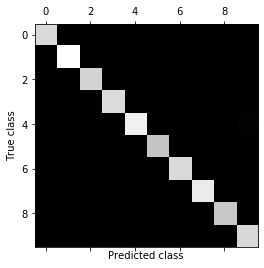

In [29]:
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.ylabel('True class')
plt.xlabel('Predicted class')

### Compute error rates

In [ ]:
row_sum = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sum
np.fill_diagonal(norm_conf_mat, 0) 

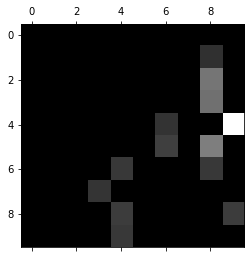

In [30]:
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)

# Predict and Submit

In [25]:
from tensorflow.keras.models import load_model
model = load_model('mnist_val_99_52.h5') # model with highest val_accuracy

In [ ]:
test = test / 255.0 #Normalize
test = test.values.reshape(-1,28,28,1) 

In [35]:
y_test_pred = model.predict(test)

In [36]:
y_test_pred = np.argmax(y_test_pred,axis = 1)

In [39]:
# Create dataframe and write to file

submit = pd.DataFrame({'ImageId': range(1,28001),                              
                       'Label': y_test_pred})

submit.to_csv('mnist1.csv', index = False)